# Inizio

In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

#i grafici verranno visualizzati direttamente sotto le loro celle, inoltre è attivo l'autoreload del kernel

In [2]:
import sys
sys.path.append("C:\\Users\\celin\\AppData\\Local\\Programs\\Python\\Python312")
sys.path.append("/Users/francescoparino/Researchs/Mac2Mic/Util/")
sys.path.append("C:\\Users\\celin\\Desktop\\polito\\magistrale\\tesi\\flu_2023")
sys.path.append("./")
#queste istruzioni servono a dire a Python in quali percorsi bisogna cercare i moduli

In [3]:
#importiamo i moduli che ci servono
import pandas as pd #si usa per manipolare e analizzare dati: file excel, csv ecc.
import numpy as np #funzioni, array multidimensionali, calcoli complessi
from numpy import ones
import scipy as spy #si usa assieme a numpy: calcola integrali, minimizza e massimizza funzionali, trasformate fourier ecc
import os #permette di manipolare file
import copy
import pickle
import itertools
import datetime #fornisce classi e funzioni per manipolare date e orari
import matplotlib #si usa per creare grafici


from glob import glob #glob lo usiamo per dire a python che file ci serve, dando come input il percorso

import seaborn as sns #seaborn aggiunge opzioni grafiche a matplotlib
blues = np.array(sns.light_palette("blue"))[[-4,-1]]
purples = np.array(sns.light_palette("purple"))[[-4,-1]]

import matplotlib.patches as mpatches #oggetti geometrici (patches) per i grafici
from collections import Counter, defaultdict #fornisce delle classi utili a manipolare dati aggregati
from itertools import combinations

from tqdm import tqdm_notebook #taqaddum, fornisce barra di avanzamento per i cicli for

import collections, functools, operator 
from bidict import bidict
from sklearn.decomposition import NMF
from matplotlib.colors import LogNorm

from multiprocessing import Pool

# LETTURA DATI INFLUCAST

In [4]:
import os
import pandas as pd


folder_path = 'C:\\Users\\celin\\Desktop\\polito\\magistrale\\tesi\\2024_46'


weekly_cases_by_region = {}


latest_files = {}


for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        # Rimuovi l'estensione .csv
        base_name = file_name[:-4]
        
        # Estrai il nome della regione e anno-settimana dal nome del file
        region_name, year_week, target = base_name.split('-')
        year, week = map(int, year_week.split('_'))
        
        # Se non abbiamo ancora visto questo anno per la regione, o se questo file ha una settimana più alta, sostituiscilo
        if region_name not in latest_files or (year, week) > (latest_files[region_name]['year'], latest_files[region_name]['week']):
            latest_files[region_name] = {'file_name': file_name, 'year_week': year_week, 'year': year, 'week': week}

# only reads last week data
for region_name, file_info in latest_files.items():
    file_name = file_info['file_name']
    file_path = os.path.join(folder_path, file_name)
    print(f"Elaborazione del file per la regione: {region_name}, settimana: {file_info['week']} del {file_info['year']}")
    
    df = pd.read_csv(file_path)
    
    
    if region_name not in weekly_cases_by_region:
        weekly_cases_by_region[region_name] = {}
    
    # adds weekly data to the dict
    for _, row in df.iterrows():
        week = f"{int(row['anno'])}_W{int(row['settimana']):02d}"  
        cases = row['incidenza']
        weekly_cases_by_region[region_name][week] = cases

# debug
print("Dizionario settimanale dei casi per regione:")
print(weekly_cases_by_region)


def normalize_region_name(region_name):
    normalized_name = region_name.lower().replace("_", " ").strip()
    return normalized_name




region_name_mapping = {
    "provincia autonoma di bolzano": "P.A. Bolzano",
    "provincia autonoma di trento": "P.A. Trento",
    "valle d'aosta": "valle d aosta",
    "emilia-romagna": "emilia romagna",
    "italia": "Italia",
    "pa trento": "trentino"
}


pop_df = pd.read_csv("popREG2.csv")


pop_df['Regione'] = pop_df['Regione'].apply(normalize_region_name)

pop_df['Regione'] = pop_df['Regione'].replace(region_name_mapping)

#print("Regioni nel file popREG2.csv:", pop_df['Regione'].unique())

pop_dict = pop_df.set_index('Regione')['PopolazioneRegionale'].to_dict()

normalized_weekly_cases_by_region = {
    normalize_region_name(region_name): weeks_data 
    for region_name, weeks_data in weekly_cases_by_region.items()
}

normalized_weekly_cases_by_region = {
    region_name_mapping.get(region_name, region_name): weeks_data 
    for region_name, weeks_data in normalized_weekly_cases_by_region.items()
}

for region_name, weeks_data in normalized_weekly_cases_by_region.items():
    # Otteniamo la popolazione generale della regione
    if region_name not in pop_dict:
        #print(f"Attenzione: la popolazione della regione {region_name} non è presente nel file popREG2.csv")
        continue
    
    # Popolazione generale della regione
    population_region = pop_dict[region_name]
    
    # Debug: Stampa la popolazione e l'incidenza prima del calcolo
    #print(f"Regione: {region_name}, Popolazione: {population_region}")
    
    # Ora aggiorniamo i dati settimanali rapportandoli alla popolazione generale
    for week, incidence_per_1000 in weeks_data.items():
        # Debug: Stampa l'incidenza prima del calcolo
        #print(f"Settimana: {week}, Incidenza per 1000 abitanti: {incidence_per_1000}")
        
        # Calcoliamo il numero totale di casi nella popolazione generale
        estimated_cases = incidence_per_1000 * population_region / 1000
        
        # Debug: Stampa il numero di casi stimati
        #print(f"Settimana: {week}, Casi stimati: {estimated_cases}")
        
        # Aggiorniamo il dizionario con i casi stimati
        normalized_weekly_cases_by_region[region_name][week] = estimated_cases

#print(normalized_weekly_cases_by_region)


pop_df = pd.read_csv("popREG2.csv")

pop_df = pop_df.replace('Emilia-Romagna', 'emilia romagna')

final_df = pd.DataFrame()

normalized_weekly_cases_by_region['emilia_romagna'] = normalized_weekly_cases_by_region['emilia romagna']

for region_name, weekly_cases in normalized_weekly_cases_by_region.items():
    #print(f"Elaborazione regione: {region_name}")
    
    region_df = pop_df[pop_df['Regione'].str.strip().str.lower() == region_name.strip().lower()]
    
    if region_df.empty:
        #print(f"ATTENZIONE: Nessun dato trovato per la regione {region_name}!")
        continue
    
    for week, total_cases in weekly_cases.items():
        #print(f"Settimana: {week}, Casi totali: {total_cases}")
        
        region_df['CasiDistribuiti'] = region_df['rapporto'] * total_cases
        
        region_df['Settimana'] = week
        
        final_df = pd.concat([final_df, region_df[['Territorio', 'Settimana', 'CasiDistribuiti']]], ignore_index=True)

#print(final_df)

final_df.to_csv('casi_distribuiti_province.csv', index=False)

import pandas as pd
import numpy as np

risultati = pd.read_csv('risultati1.csv')
dati_reali = pd.read_csv('casi_distribuiti_province.csv')

risultati['Settimana'] = pd.to_datetime(risultati['Date']).dt.isocalendar().week
risultati['Anno'] = pd.to_datetime(risultati['Date']).dt.year
risultati['Settimana_Anno'] = risultati['Anno'].astype(str) + '_W' + risultati['Settimana'].astype(str)

dati_reali['Anno'] = dati_reali['Settimana'].apply(lambda x: int(x.split('_W')[0]))
dati_reali['Settimana_Numero'] = dati_reali['Settimana'].apply(lambda x: int(x.split('_W')[1]))

def espandi_settimana_a_giorni(df):
    expanded_rows = []
    for _, row in df.iterrows():
        inizio_settimana = pd.to_datetime(f'{row["Anno"]}-W{int(row["Settimana_Numero"])}-1', format='%Y-W%W-%w')
        for i in range(7):
            giorno = inizio_settimana + pd.Timedelta(days=i)
            expanded_rows.append({
                'Territorio': row['Territorio'],
                'Data': giorno,
                'Settimana_Numero': row['Settimana_Numero'],
                'CasiDistribuiti': row['CasiDistribuiti']  # non distribuiamo qui
            })
    return pd.DataFrame(expanded_rows)

dati_reali_giornalieri = espandi_settimana_a_giorni(dati_reali)

def normalize_province_name(province_name):
    return province_name.strip().lower().replace("'", "").replace(" ", "").replace("-", "")

risultati['Provincia_Normalizzata'] = risultati['Province'].apply(normalize_province_name)
dati_reali_giornalieri['Provincia_Normalizzata'] = dati_reali_giornalieri['Territorio'].apply(normalize_province_name)

dati_reali_giornalieri = dati_reali_giornalieri.sort_values(['Provincia_Normalizzata', 'Data'])
dati_reali_giornalieri['CasiDistribuiti'] = dati_reali_giornalieri.groupby('Provincia_Normalizzata')['CasiDistribuiti'].transform(lambda x: x.interpolate(method='linear'))

risultati['Date'] = pd.to_datetime(risultati['Date'])
dati_reali_giornalieri['Data'] = pd.to_datetime(dati_reali_giornalieri['Data'])

confronto = pd.merge(risultati, dati_reali_giornalieri, left_on=['Provincia_Normalizzata', 'Date'], right_on=['Provincia_Normalizzata', 'Data'], how='inner')

confronto.to_csv('confronto_risultati_reali_simulati_giornaliero.csv', index=False)

confronto.head()


Elaborazione del file per la regione: abruzzo, settimana: 46 del 2024
Elaborazione del file per la regione: basilicata, settimana: 45 del 2024
Elaborazione del file per la regione: calabria, settimana: 45 del 2024
Elaborazione del file per la regione: campania, settimana: 46 del 2024
Elaborazione del file per la regione: emilia_romagna, settimana: 46 del 2024
Elaborazione del file per la regione: friuli_venezia_giulia, settimana: 46 del 2024
Elaborazione del file per la regione: italia, settimana: 46 del 2024
Elaborazione del file per la regione: lazio, settimana: 46 del 2024
Elaborazione del file per la regione: liguria, settimana: 46 del 2024
Elaborazione del file per la regione: lombardia, settimana: 46 del 2024
Elaborazione del file per la regione: marche, settimana: 46 del 2024
Elaborazione del file per la regione: molise, settimana: 46 del 2024
Elaborazione del file per la regione: pa_bolzano, settimana: 46 del 2024
Elaborazione del file per la regione: pa_trento, settimana: 46 d

C:\Users\celin\AppData\Local\Temp\ipykernel_1604\1180748423.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['CasiDistribuiti'] = region_df['rapporto'] * total_cases
C:\Users\celin\AppData\Local\Temp\ipykernel_1604\1180748423.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['Settimana'] = week
C:\Users\celin\AppData\Local\Temp\ipykernel_1604\1180748423.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

,Date,Province,Suscettibili,Esposti,Infetti,Non Contagiosi,Rimossi,Morti,Settimana,Anno,Settimana_Anno,Provincia_Normalizzata,Territorio,Data,Settimana_Numero,CasiDistribuiti


# Funzioni

In [5]:
from engine1 import parameters, readFluDataset1, readFluDatasetInflucast, normalizeNameProvince, aggiungiProvinceMancanti
nh, Whk, initial_case_i, initial_case_e, orderedPROV, flu_init_dict = readFluDataset1()
flu_file = 'casi_distribuiti_province.csv'  # Inserisci il percorso del tuo file
nh, Whk, initial_case_i, initial_case_e, orderedPROV, flu_init_dict, flu_df, recent_flu_df = readFluDatasetInflucast(flu_file)
# verifichiamo di aver letto bene il file .csv coi dati reali
print("Popolazioni:", nh)
print("Matrice di flusso (Whk):", Whk)
print("Casi iniziali (I):", initial_case_i)


Popolazioni: [2243382  176576  181868  160079  365286  586113  217407  426952  126620
  214073  280625  853939  218702  871334  586795  336127  180766 3035443
 1086890 1238075  535666  223659  357581  408187  504708  524877  899817
  858732  209720  876051  846275  920895  242167  310611  534944  139914
  232311  284440  427164  517772  685822  976053  352856  384428  390677
  322028  199437  387625  287645  972232  245299  334870  410728  343298
  266522  220124  655006  228209  362676  473642  319375  210182  312674
  154909 3995250  544887  492302  298087  306177  314391  387761   86989
  226156  905188  284560 3053247  428855 1092574  625657 1246742  584229
  400504  801170  377512  200050  713869  170718  359783  163216  550832
  429537 1242560  649320  272906  173377 1078045  307697  327751  159103
  549893  174813  391770  446520  399892  163678  840358  437421]
Matrice di flusso (Whk): [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.     

In [6]:
# debug per readFluDatasetInflucast(flu_file)

missing_provinces = [prov for prov in orderedPROV if prov not in flu_init_dict]
print("Province senza dati iniziali:", missing_provinces)

print(flu_init_dict)
print(recent_flu_df[['Territorio', 'Anno', 'Settimana', 'CasiDistribuiti']])

Province senza dati iniziali: ['valledaosta', 'reggioemilia', 'potenza', 'matera', 'cosenza', 'crotone', 'catanzaro', 'vibovalentia', 'reggiocalabria', 'monzaebrianza']
{'agrigento': 3247.2567657472296, 'alessandria': 3007.5146723211565, 'ancona': 3164.6049023035403, 'arezzo': 1586.1002040081614, 'ascolipiceno': 1404.3158916987145, 'asti': 1531.447896637853, 'avellino': 924.1516388794364, 'bari': 6098.407147542858, 'barletta-andria-trani': 1916.3331051595803, 'belluno': 1205.3751844497478, 'benevento': 613.206305999772, 'bergamo': 9666.751805914386, 'biella': 1281.1057880644755, 'bologna': 7078.639139080594, 'bolzano': 1540.7863020971574, 'brescia': 11011.384539472672, 'brindisi': 1959.0552465702635, 'cagliari': 2235.971536643028, 'caltanissetta': 1984.672254127504, 'campobasso': 545.19001112622, 'caserta': 1950.6149483951428, 'catania': 7839.937561654517, 'chieti': 3184.042484826846, 'como': 5218.928894323741, 'cremona': 3180.309670261633, 'cuneo': 4128.668906898597, 'enna': 1260.8609

In [7]:
# crea i compartimenti iniziali ricevendo come input una istanza della classe parameters e, volendo, anche gli esposti e infetti iniziali. 
# restituisce come output le matrici S, E, I, N, R all'istante t = 0
from datetime import datetime, timedelta

regioni_info = {
    "abruzzo": {
        "province": {"Teramo": 306177, "Pescara": 314391, "L'Aquila": 298087, "Chieti": 387761},
        "abitanti": sum([306177, 314391, 298087, 387761])
    },
    "basilicata": {
        "province": {"Potenza": 377512, "Matera": 200050},
        "abitanti": sum([377512, 200050])
    },
    "calabria": {
        "province": {"Cosenza": 713869, "Reggio Calabria": 550832, "Catanzaro": 359783, "Crotone": 170718, "Vibo Valentia": 163216},
        "abitanti": sum([713869, 550832, 359783, 170718, 163216])
    },
    "campania": {
        "province": {"Napoli": 3053247, "Salerno": 1092574, "Caserta": 905188, "Benevento": 284560, "Avellino": 428855},
        "abitanti": sum([3053247, 1092574, 905188, 284560, 428855])
    },
    "emilia_romagna": {
        "province": {"Bologna": 976053, "Rimini": 322028, "Modena": 685822, "Parma": 427164, "Reggio Emilia": 517772, "Ferrara": 352856, "Ravenna": 384428, "Forlì-Cesena": 390677, "Piacenza": 284440},
        "abitanti": sum([976053, 322028, 685822, 427164, 517772, 352856, 384428, 390677, 284440])
    },
    "friuli_venezia_giulia": {
        "province": {"Trieste": 232311, "Udine": 534944, "Gorizia": 139914, "Pordenone": 310611},
        "abitanti": sum([232311, 534944, 139914, 310611])
    },
    "lazio": {
        "province": {"Roma": 3995250, "Latina": 544887, "Frosinone": 492302, "Viterbo": 312674, "Rieti": 154909},
        "abitanti": sum([3995250, 544887, 492302, 312674, 154909])
    },
    "liguria": {
        "province": {"Genova": 1238075, "Savona": 357581, "La Spezia": 387625, "Imperia": 214073},
        "abitanti": sum([1238075, 357581, 387625, 214073])
    },
    "lombardia": {
        "province": {"Milano": 3035443, "Bergamo": 1086890, "Brescia": 1238075, "Como": 586795, "Cremona": 357581, "Lecco": 387625, "Lodi": 223659, "Mantova": 408187, "Monza e Brianza": 840358, "Pavia": 535666, "Sondrio": 180766, "Varese": 871334},
        "abitanti": sum([3035443, 1086890, 1238075, 586795, 357581, 387625, 223659, 408187, 840358, 535666, 180766, 871334])
    },
    "marche": {
        "province": {"Ancona": 473642, "Pesaro e Urbino": 362676, "Macerata": 319375, "Ascoli Piceno": 210182, "Fermo": 174813},
        "abitanti": sum([473642, 362676, 319375, 210182, 174813])
    },
    "molise": {
        "province": {"Campobasso": 226156, "Isernia": 86989},
        "abitanti": sum([226156, 86989])
    },
    "piemonte": {
        "province": {"Torino": 2243382, "Cuneo": 586795, "Asti": 357581, "Alessandria": 871334, "Biella": 181868, "Novara": 365286, "Verbano-Cusio-Ossola": 160079, "Vercelli": 176576},
        "abitanti": sum([2243382, 586795, 357581, 871334, 181868, 365286, 160079, 176576])
    },
    "puglia": {
        "province": {"Bari": 1246742, "Taranto": 584229, "Brindisi": 400504, "Foggia": 625657, "Lecce": 801170, "Barletta-Andria-Trani": 391770},
        "abitanti": sum([1246742, 584229, 400504, 625657, 801170, 391770])
    },
    "sardegna": {
        "province": {"Cagliari": 549893, "Sassari": 327751, "Nuoro": 159103, "Oristano": 163678, "Sud Sardegna": 437421},
        "abitanti": sum([549893, 327751, 159103, 163678, 437421])
    },
    "sicilia": {
        "province": {"Palermo": 1242560, "Catania": 1078045, "Messina": 649320, "Siracusa": 399892, "Ragusa": 307697, "Trapani": 429537, "Caltanissetta": 272906, "Enna": 173377, "Agrigento": 446520},
        "abitanti": sum([1242560, 1078045, 649320, 399892, 307697, 429537, 272906, 173377, 446520])
    },
    "toscana": {
        "province": {"Firenze": 972232, "Prato": 245299, "Pistoia": 287645, "Livorno": 334870, "Lucca": 387625, "Pisa": 410728, "Arezzo": 343298, "Siena": 266522, "Grosseto": 220124, "Massa-Carrara": 199437},
        "abitanti": sum([972232, 245299, 287645, 334870, 387625, 410728, 343298, 266522, 220124, 199437])
    },
    "trentino-alto adige": {
        "province": {"Trento": 524877, "Bolzano": 504708},
        "abitanti": sum([524877, 504708])
    },
    "pa_trento": {
        "province": {"Trento": 524877},
        "abitanti": 524877
    },
    "pa_bolzano": {
        "province": {"Bolzano": 504708},
        "abitanti": 504708
    },
    "umbria": {
        "province": {"Perugia": 655006, "Terni": 228209},
        "abitanti": sum([655006, 228209])
    },
    "valle_d_aosta": {
        "province": {"Aosta": 126620},
        "abitanti": sum([126620])
    },
    "veneto": {
        "province": {"Venezia": 846275, "Verona": 899817, "Padova": 920895, "Vicenza": 858732, "Treviso": 876051, "Belluno": 209720, "Rovigo": 242167},
        "abitanti": sum([846275, 899817, 920895, 858732, 876051, 209720, 242167])
    }
}

def initialStates(p, initialCaseI=None, initialCaseE=None, start_date=None):
    shape = (3, p.Whk.shape[0])  # Tre classi: giovani, anziani, anziani vaccinati
    
    I = np.zeros(shape)
    E = np.zeros(shape)
    N = np.zeros(shape)
    R = np.zeros(shape)
    
    # Distribuzione degli infetti iniziali
    if initialCaseI is not None:
        I[0] = initialCaseI * p.eta[0]  # Giovani
        I[1] = initialCaseI * p.eta[1]  # Anziani
        I[2] = initialCaseI * p.eta[2]  # Anziani vaccinati
        
    # Distribuzione degli esposti iniziali
    if initialCaseE is not None:
        E[0] = initialCaseE * p.eta[0]  # Giovani
        E[1] = initialCaseE * p.eta[1]  # Anziani
        E[2] = initialCaseE * p.eta[2]  # Anziani vaccinati
    
    # Calcoliamo i suscettibili iniziali
    Stot = np.ones(shape) * p.eta.reshape(-1, 1).dot(p.nh.reshape(1, -1))
    S = Stot - E - I - N
    
    #verifichiamo che il numero di suscettibili non sia negativo
    if np.any(S < 0):
        raise ValueError("Numero negativo di suscettibili, errore nell'inizializzazione.")

    if start_date is not None:
        start_date = datetime.strptime(start_date, '%d-%m-%Y')
    else:
        start_date = datetime.now()
    
    return S, E, I, N, R, start_date


# this function advances our model by one time step (one day)
def oneStep(SEINR, p):
    S, E, I, N, R = SEINR
    Lambda, Nu, Beta, Gamma = p.Lambda, p.Nu, p.Beta, p.Gamma
    m, eta, ai, alpha, nh, b, Whk = p.m, p.eta, p.ai, p.alpha, p.nh, p.b, p.Whk
    aAvg = (eta * ai * alpha).sum()
    nhTilde = (1 - b * aAvg) * nh + (b * aAvg * (Whk @ nh))
    ph = (1 / nhTilde) * (((1 - b) * alpha * ai).reshape(-1, 1) * I).sum(0) + (Whk @ (((b * alpha * ai).reshape(-1, 1) * I).sum(0).reshape(-1, 1))).sum(0)
    PIt1 = (alpha * ai * (1 - b) * Lambda * m).reshape(-1, 1) * ph
    PIt2 = ((1 - alpha * ai * b) * Lambda * m).reshape(-1, 1) * ph
    PI = PIt1 + PIt2
    St1 = (1 - PI) * S
    Et1 = PI * S + (1 - Nu) * E
    It1 = Nu * E + (1 - Beta) * I
    Nt1 = Beta * I + (1 - Gamma) * N
    Rt1 = R + Gamma * N
    S, E, I, N, R = St1, Et1, It1, Nt1, Rt1

    # these conditions make sure that there no compartments with <0 people
    if S.min().min() < 0:
        E += np.minimum(0, S)
        S = np.maximum(0, S)
    if E.min().min() < 0:
        I += np.minimum(0, E)
        E = np.maximum(0, E)
    if I.min().min() < 0:
        N += np.minimum(0, I)
        I = np.maximum(0, I)
    if N.min().min() < 0:
        R += np.minimum(0, N)
        N = np.maximum(0, N)
    R = np.maximum(0, R)

    _nh = S.sum(0) + E.sum(0) + I.sum(0) + N.sum(0) + R.sum(0)
    assert np.isclose(nh, _nh, rtol=0, atol=1e-2).all(), f"Population not preserved! {nh}, {_nh}"

    return S, E, I, N, R



def calculate_deaths(R, mortality_rate):
    deaths = (R * mortality_rate.reshape(-1, 1)).sum(axis=0)
    return deaths


def vaccinate_elders(S, p, vaccinate_rate):
    vaccinated_elderly_idx = 2  # index for the new class of vaccinated elder people
    elderly_idx = 1  # index for the class of elder people who choose not to vaccinate
    
    
    num_elderly_to_vaccinate = S[elderly_idx] * vaccinate_rate
    
    # our assumption is that only people in the S compartment get vaccinated
    S[vaccinated_elderly_idx] += num_elderly_to_vaccinate
    S[elderly_idx] -= num_elderly_to_vaccinate
    
    return S


def save_results(filename, results):
    df = pd.DataFrame(results)
    df.to_csv(filename, index=False)

In [7]:
# Esempio di esecuzione della simulazione con tre classi di cittadini
#nh = np.array([1000, 2000, 1500])
#Whk = np.array([[0.3, 0.2, 0.5], [0.2, 0.4, 0.4], [0.5, 0.4, 0.1]])

#params = parameters(nh, Whk)

#initial_case_i = np.array([100, 50, 0])
#initial_case_e = np.array([20, 10, 0])
#start_date = '01-01-2020'

# Simulazioni

In [8]:
# SIMULAZIONI

results = {
    'Date': [],
    'Province': [],
    'Suscettibili': [],
    'Esposti': [],
    'Infetti': [],
    'Non Contagiosi': [],
    'Rimossi': [],
    'Morti': []
}

vaccinate_day = 30
vaccinate_rate = 0.5

params = parameters(nh, Whk)
#S, E, I, N, R, current_date = initialStates(params, initial_case_i, initial_case_e, '13-11-2017')
S, E, I, N, R, current_date = initialStates(params, initial_case_i, initial_case_e)
zero_date = current_date - timedelta(days=1)

# we use real data to establish initial conditions
for province_idx, province in enumerate(orderedPROV):
    results['Date'].append(zero_date.strftime('%Y-%m-%d'))  # t = 0
    results['Province'].append(province)
    results['Suscettibili'].append(S[:, province_idx].sum())
    results['Esposti'].append(E[:, province_idx].sum())
    results['Infetti'].append(I[:, province_idx].sum())
    results['Non Contagiosi'].append(N[:, province_idx].sum())
    results['Rimossi'].append(R[:, province_idx].sum())
    results['Morti'].append(0)  
    
for day in range(120):
    current_date_step = current_date + timedelta(days=day)
    if day == vaccinate_day:
        S = vaccinate_elders(S, params, vaccinate_rate)
    
    S, E, I, N, R = oneStep((S, E, I, N, R), params)
    deaths = calculate_deaths(R, np.array([0.001, 0.05, 0.02]))  # mortality rates for each class
    
    for province_idx, province in enumerate(orderedPROV):
        results['Date'].append(current_date_step.strftime('%Y-%m-%d'))
        results['Province'].append(province)
        results['Suscettibili'].append(S[:, province_idx].sum())
        results['Esposti'].append(E[:, province_idx].sum())
        results['Infetti'].append(I[:, province_idx].sum())
        results['Non Contagiosi'].append(N[:, province_idx].sum())
        results['Rimossi'].append(R[:, province_idx].sum())
        results['Morti'].append(deaths[province_idx])


total_deaths = deaths.sum()
print(f"Numero totale di morti in tutte le province: {total_deaths}")

save_results('risultati1.csv', results)

Numero totale di morti in tutte le province: 619082.8602282607


In [9]:
params.Lambda

array([5.330e-08, 6.929e-08, 6.396e-08])

# Grafici e salvataggio dati

C:\Users\celin\AppData\Local\Temp\ipykernel_1604\3212959807.py:43: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  infected_by_region = infected_df.groupby(level=0, axis=1).sum()
C:\Users\celin\AppData\Local\Temp\ipykernel_1604\3212959807.py:44: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  removed_by_region = removed_df.groupby(level=0, axis=1).sum()
C:\Users\celin\AppData\Local\Temp\ipykernel_1604\3212959807.py:45: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  deaths_by_region = deaths_df.groupby(level=0, axis=1).sum()


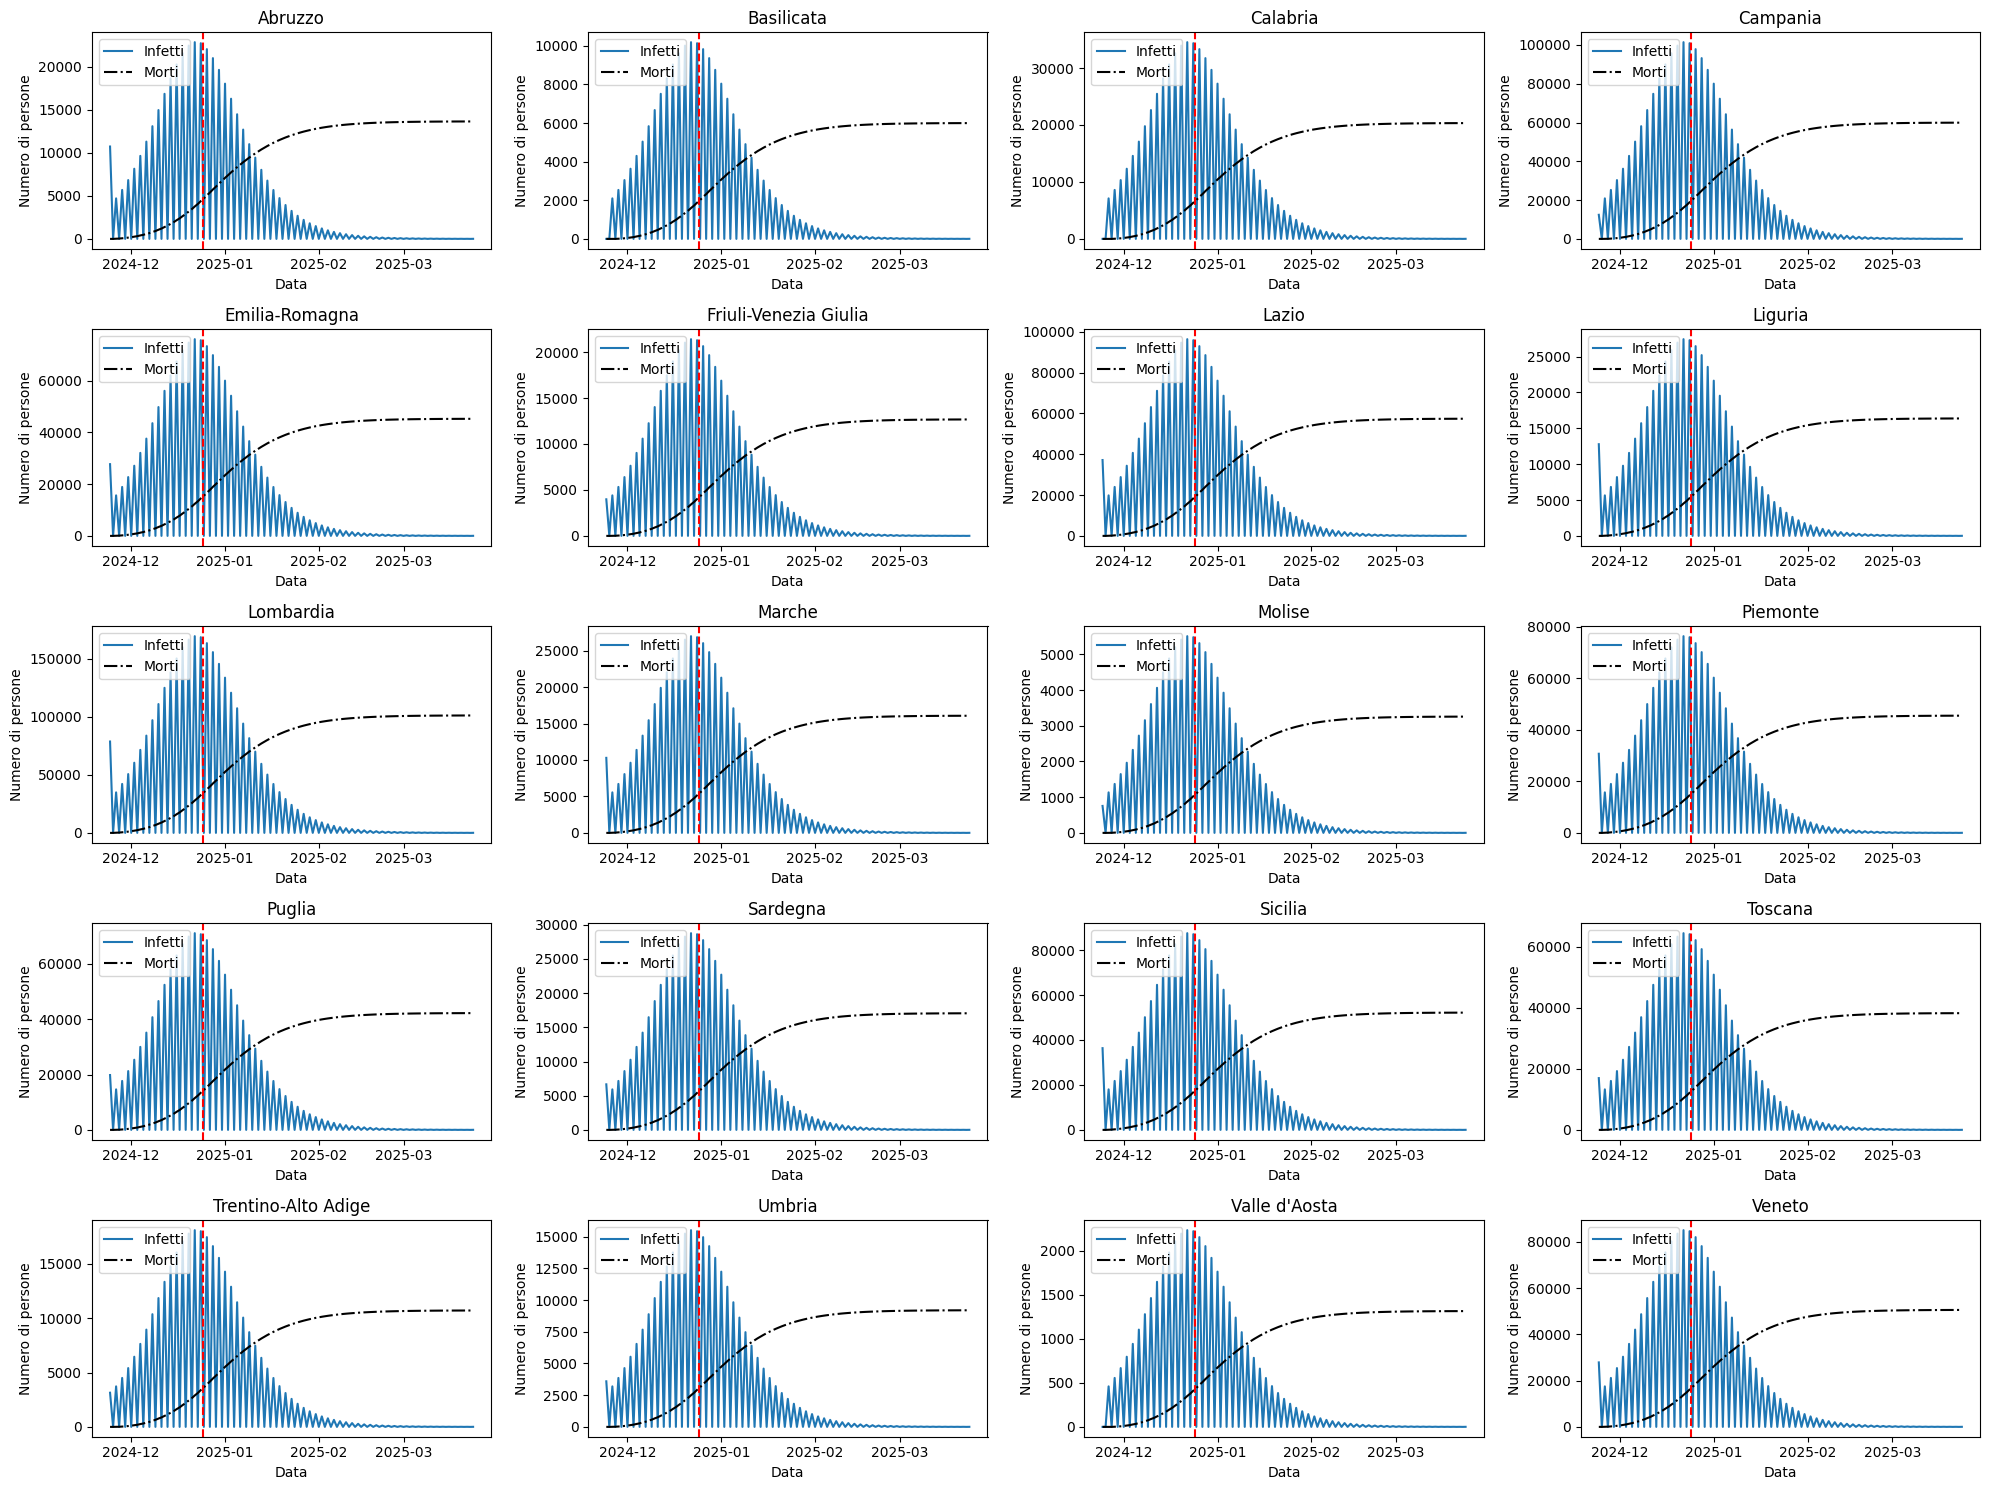

In [10]:
# GRAFICI

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import matplotlib.dates as mdates

province_classification_df = pd.read_csv('popREG.csv')

province_classification_df["Territorio"] = province_classification_df['Territorio'].apply(normalizeNameProvince)


dictProvinceRegioni = dict(province_classification_df[["Territorio", "Regione"]])



dictProvinceRegioni = aggiungiProvinceMancanti(dictProvinceRegioni)


results_df = pd.DataFrame(results)
infected_df = results_df.pivot(index='Date', columns='Province', values='Infetti')

# Normalizziamo i nomi delle province nel DataFrame e nel dizionario
infected_df.columns = [normalizeNameProvince(prov) for prov in infected_df.columns]

infected_df.columns = [dictProvinceRegioni[prov] for prov in infected_df.columns]

vaccination_date = zero_date + timedelta(days=vaccinate_day)


results_df['Date'] = pd.to_datetime(results_df['Date'])
infected_df = results_df.pivot(index='Date', columns='Province', values='Infetti')
removed_df = results_df.pivot(index='Date', columns='Province', values='Rimossi')
deaths_df = results_df.pivot(index='Date', columns='Province', values='Morti')


infected_df.columns = [dictProvinceRegioni[prov] for prov in infected_df.columns]
removed_df.columns = [dictProvinceRegioni[prov] for prov in removed_df.columns]
deaths_df.columns = [dictProvinceRegioni[prov] for prov in deaths_df.columns]


infected_by_region = infected_df.groupby(level=0, axis=1).sum()
removed_by_region = removed_df.groupby(level=0, axis=1).sum()
deaths_by_region = deaths_df.groupby(level=0, axis=1).sum()


num_regions = len(infected_by_region.columns)


cols = 4  
rows = math.ceil(num_regions / cols)  


fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
axes = axes.flatten()  


for i, region in enumerate(infected_by_region.columns):
    ax = axes[i]
    
    # num of infected people
    ax.plot(infected_by_region.index, infected_by_region[region], label='Infetti')
    
    
    #ax.plot(removed_by_region.index, removed_by_region[region], label='Rimossi', color='green')
    
    
    ax.plot(deaths_by_region.index, deaths_by_region[region], label='Morti', color='black', linestyle='-.')
    
    # Configurazioni grafiche
    ax.set_title(region)
    ax.set_xlabel('Data')
    ax.set_ylabel('Numero di persone')
    ax.legend(loc='upper left')
    
    # Configura i tick delle date per mostrare solo l'inizio di ogni mese
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    # Aggiungi una linea verticale al giorno delle vaccinazioni
    ax.axvline(vaccination_date, color='red', linestyle='--', label='Vaccinazioni')


for i in range(num_regions, len(axes)):
    fig.delaxes(axes[i])


plt.tight_layout()
plt.show()


# Simulazioni per Influcast

In [11]:
# tutte queste info ci servono per trasformare i dati delle simulazioni provinciali in dati regionali
# da inviare a influcast

regioni_info = {
    "abruzzo": {
        "province": {"Teramo": 306177, "Pescara": 314391, "L'Aquila": 298087, "Chieti": 387761},
        "abitanti": sum([306177, 314391, 298087, 387761])
    },
    "basilicata": {
        "province": {"Potenza": 377512, "Matera": 200050},
        "abitanti": sum([377512, 200050])
    },
    "calabria": {
        "province": {"Cosenza": 713869, "Reggio Calabria": 550832, "Catanzaro": 359783, "Crotone": 170718, "Vibo Valentia": 163216},
        "abitanti": sum([713869, 550832, 359783, 170718, 163216])
    },
    "campania": {
        "province": {"Napoli": 3053247, "Salerno": 1092574, "Caserta": 905188, "Benevento": 284560, "Avellino": 428855},
        "abitanti": sum([3053247, 1092574, 905188, 284560, 428855])
    },
    "emilia_romagna": {
        "province": {"Bologna": 976053, "Rimini": 322028, "Modena": 685822, "Parma": 427164, "Reggio Emilia": 517772, "Ferrara": 352856, "Ravenna": 384428, "Forlì-Cesena": 390677, "Piacenza": 284440},
        "abitanti": sum([976053, 322028, 685822, 427164, 517772, 352856, 384428, 390677, 284440])
    },
    "friuli_venezia_giulia": {
        "province": {"Trieste": 232311, "Udine": 534944, "Gorizia": 139914, "Pordenone": 310611},
        "abitanti": sum([232311, 534944, 139914, 310611])
    },
    "lazio": {
        "province": {"Roma": 3995250, "Latina": 544887, "Frosinone": 492302, "Viterbo": 312674, "Rieti": 154909},
        "abitanti": sum([3995250, 544887, 492302, 312674, 154909])
    },
    "liguria": {
        "province": {"Genova": 1238075, "Savona": 357581, "La Spezia": 387625, "Imperia": 214073},
        "abitanti": sum([1238075, 357581, 387625, 214073])
    },
    "lombardia": {
        "province": {"Milano": 3035443, "Bergamo": 1086890, "Brescia": 1238075, "Como": 586795, "Cremona": 357581, "Lecco": 387625, "Lodi": 223659, "Mantova": 408187, "Monza e Brianza": 840358, "Pavia": 535666, "Sondrio": 180766, "Varese": 871334},
        "abitanti": sum([3035443, 1086890, 1238075, 586795, 357581, 387625, 223659, 408187, 840358, 535666, 180766, 871334])
    },
    "marche": {
        "province": {"Ancona": 473642, "Pesaro e Urbino": 362676, "Macerata": 319375, "Ascoli Piceno": 210182, "Fermo": 174813},
        "abitanti": sum([473642, 362676, 319375, 210182, 174813])
    },
    "molise": {
        "province": {"Campobasso": 226156, "Isernia": 86989},
        "abitanti": sum([226156, 86989])
    },
    "piemonte": {
        "province": {"Torino": 2243382, "Cuneo": 586795, "Asti": 357581, "Alessandria": 871334, "Biella": 181868, "Novara": 365286, "Verbano-Cusio-Ossola": 160079, "Vercelli": 176576},
        "abitanti": sum([2243382, 586795, 357581, 871334, 181868, 365286, 160079, 176576])
    },
    "puglia": {
        "province": {"Bari": 1246742, "Taranto": 584229, "Brindisi": 400504, "Foggia": 625657, "Lecce": 801170, "Barletta-Andria-Trani": 391770},
        "abitanti": sum([1246742, 584229, 400504, 625657, 801170, 391770])
    },
    "sardegna": {
        "province": {"Cagliari": 549893, "Sassari": 327751, "Nuoro": 159103, "Oristano": 163678, "Sud Sardegna": 437421},
        "abitanti": sum([549893, 327751, 159103, 163678, 437421])
    },
    "sicilia": {
        "province": {"Palermo": 1242560, "Catania": 1078045, "Messina": 649320, "Siracusa": 399892, "Ragusa": 307697, "Trapani": 429537, "Caltanissetta": 272906, "Enna": 173377, "Agrigento": 446520},
        "abitanti": sum([1242560, 1078045, 649320, 399892, 307697, 429537, 272906, 173377, 446520])
    },
    "toscana": {
        "province": {"Firenze": 972232, "Prato": 245299, "Pistoia": 287645, "Livorno": 334870, "Lucca": 387625, "Pisa": 410728, "Arezzo": 343298, "Siena": 266522, "Grosseto": 220124, "Massa-Carrara": 199437},
        "abitanti": sum([972232, 245299, 287645, 334870, 387625, 410728, 343298, 266522, 220124, 199437])
    },
    "trentino-alto adige": {
        "province": {"Trento": 524877, "Bolzano": 504708},
        "abitanti": sum([524877, 504708])
    },
    "pa_trento": {
        "province": {"Trento": 524877},
        "abitanti": 524877
    },
    "pa_bolzano": {
        "province": {"Bolzano": 504708},
        "abitanti": 504708
    },
    "umbria": {
        "province": {"Perugia": 655006, "Terni": 228209},
        "abitanti": sum([655006, 228209])
    },
    "valle_d_aosta": {
        "province": {"Aosta": 126620},
        "abitanti": sum([126620])
    },
    "veneto": {
        "province": {"Venezia": 846275, "Verona": 899817, "Padova": 920895, "Vicenza": 858732, "Treviso": 876051, "Belluno": 209720, "Rovigo": 242167},
        "abitanti": sum([846275, 899817, 920895, 858732, 876051, 209720, 242167])
    }
}

# associamo ogni codice a una regione e al suo numero di abitanti
popolazione_regioni = {
    "01": regioni_info["abruzzo"]["abitanti"],
    "02": regioni_info["basilicata"]["abitanti"],
    "03": regioni_info["calabria"]["abitanti"],
    "04": regioni_info["campania"]["abitanti"],
    "05": regioni_info["emilia_romagna"]["abitanti"],
    "06": regioni_info["friuli_venezia_giulia"]["abitanti"],
    "07": regioni_info["lazio"]["abitanti"],
    "08": regioni_info["liguria"]["abitanti"],
    "09": regioni_info["lombardia"]["abitanti"],
    "10": regioni_info["marche"]["abitanti"],
    "11": regioni_info["molise"]["abitanti"],
    "12": regioni_info["pa_bolzano"]["abitanti"],
    "13": regioni_info["pa_trento"]["abitanti"],
    "14": regioni_info["piemonte"]["abitanti"],
    "15": regioni_info["puglia"]["abitanti"],
    "16": regioni_info["sardegna"]["abitanti"],
    "17": regioni_info["sicilia"]["abitanti"],
    "18": regioni_info["toscana"]["abitanti"],
    "19": regioni_info["umbria"]["abitanti"],
    "20": regioni_info["valle_d_aosta"]["abitanti"],
    "21": regioni_info["veneto"]["abitanti"],
    "IT": sum(regioni_info[regione]["abitanti"] for regione in regioni_info)  # Popolazione totale Italia
}

In [14]:
import pandas as pd
import numpy as np
from datetime import timedelta


# Estrarre i dati reali degli infetti (CasiDistribuiti) a partire dal confronto reali+simulati
# real_infected = confronto[['Date', 'Province', 'CasiDistribuiti']]

# estrai i dati reali a partire da casi_distribuiti_province
file_path = 'casi_distribuiti_province.csv'  # Sostituisci con il percorso reale del file
real_infected = pd.read_csv(file_path)
real_infected['Anno'] = real_infected['Settimana'].str.split('_W').str[0].astype(int)
real_infected['SettimanaISO'] = real_infected['Settimana'].str.split('_W').str[1].astype(int)
real_infected['Date'] = real_infected.apply(
    lambda row: datetime.strptime(f'{row.Anno}-W{int(row.SettimanaISO):02}-1', "%Y-W%U-%w"), axis=1
)

#trova la prima data disponibile nei dati reali
first_date = pd.to_datetime(real_infected['Date']).min()
first_date_str = first_date.strftime('%d-%m-%Y')



# associamo province-regioni
provincia_to_regione = aggiungiProvinceMancanti({})
region_to_code = {  
    'Abruzzo': '01', 'Basilicata': '02', 'Calabria': '03', 'Campania': '04',
    'Emilia-Romagna': '05', 'Friuli-Venezia Giulia': '06', 'Lazio': '07',
    'Liguria': '08', 'Lombardia': '09', 'Marche': '10', 'Molise': '11',
    'Provincia autonoma di Bolzano': '12', 'Provincia autonoma di Trento': '13', 
    'Piemonte': '14', 'Puglia': '15', 'Sardegna': '16', 'Sicilia': '17',
    'Toscana': '18', 'Umbria': '19', 'Valle d\'Aosta': '20', 'Veneto': '21', 'Italia': 'IT'
}

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from numpy import linalg as LA
import time

# misuriamo quanto durano le simulazioni
start_time = time.time()

t = 120 # t giorni di simulazione
n = 0
# variamo nu e lambda
nu_values = np.linspace(0.25, 0.28, 5)
lambda_values = np.linspace(5.18e-8, 5.58e-8, 5)

# se per sfizio vogliamo variare b e ai
#b_values = np.linspace(0.15, 0.45, 5)  # Tasso di contatto tra province
#ai_values = [  # Livelli di attività per giovani, anziani, e anziani vaccinati
#    np.array([0.1, 0.4, 0.4]),
#    np.array([0.2, 0.5, 0.5]),
#    np.array([0.15, 0.45, 0.45]),
#    np.array([0.25, 0.55, 0.55]),
#    np.array([0.3, 0.6, 0.6])
#]

# variamo gamma e beta
gamma_values = np.linspace(0.10, 0.10, 1)
beta_values = np.linspace(2.25, 2.55, 5)


min_error = float('inf')
optimal_params = {}
error_data = []
risultati_provinciali = []
risultati_regionali = []
risultati_simulazioni = []
total_error = 0
for lam in lambda_values:
    for nu in nu_values:
        for beta in beta_values:
            for gamma in gamma_values:
                
                # imponiamo una data combinazione di parametri
                params.Lambda = np.array([lam, lam * 1.3, lam * 1.2])
                params.Nu = nu
                params.Beta = beta
                params.Gamma = gamma

                # impostiamo condizioni iniziali
                S, E, I, N, R, current_date = initialStates(params, initial_case_i, initial_case_e, first_date_str)
                
                total_error = 0
                risultati_giornalieri = []

                for day in range(t):
                    current_date_step = current_date + timedelta(days=day)
                    if day == vaccinate_day:
                        S = vaccinate_elders(S, params, vaccinate_rate)
                    S, E, I, N, R = oneStep((S, E, I, N, R), params)

                    simulated_infected = I.sum(axis=0)  # Totale infetti in una provincia
                    
                    # salviamo il totale
                    for provincia, infetti in zip(orderedPROV, simulated_infected):
                        risultati_giornalieri.append({
                            "Lambda": lam, "Nu": nu, "Beta": beta, "Gamma": gamma,
                            "giorno": current_date_step, "provincia": provincia, "infetti": infetti
                        })

                    # confrontiamo errore (utile se vogliamo trovare combinazione ideale dei parametri)
                    #daily_real_data = real_infected[real_infected['Date'] == current_date_step.strftime('%Y-%m-%d')]
                    #common_provinces = daily_real_data['Territorio'].values
                    #province_mask = [province in common_provinces for province in orderedPROV]

                    #filtered_simulated_infected = simulated_infected[province_mask]
                    #filtered_real_infected = daily_real_data['CasiDistribuiti'].values

                    #if len(filtered_real_infected) > 0:
                    #    error = LA.norm(filtered_simulated_infected - filtered_real_infected, ord=1)
                    #    total_error += error

                # Media dell'errore
                #total_error /= t
                n += 1
                
                risultati_provinciali.extend(risultati_giornalieri)

                # se abbiamo trovato una combinazione di parametri che riduce l'errore totale, la salviamo
                if total_error < min_error:
                    min_error = total_error
                    optimal_params = {'Lambda': lam, 'Nu': nu, 'Beta': beta, 'Gamma': gamma}

                # Salvataggio dei dati dell'errore
                error_data.append({
                    'Lambda': lam, 'Nu': nu, 'Beta': beta, 'Gamma': gamma, 'Error': total_error
                })


error_df = pd.DataFrame(error_data)

#tempo totale impiegato
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Tempo totale richiesto per la simulazione: {elapsed_time:.2f} secondi, per un totale di {n} combinazioni di parametri. ")
print(f"Parametri ottimali trovati: {optimal_params}, con errore medio: {min_error}")
print(f"nota bene: la stima dell'errore e dei parametri ottimali ha senso solo se abbiamo abbastanza dati reali con cui fare il confronto")

Tempo totale richiesto per la simulazione: 6.88 secondi, per un totale di 125 combinazioni di parametri. 
Parametri ottimali trovati: {'Lambda': 5.18e-08, 'Nu': 0.25, 'Beta': 2.25, 'Gamma': 0.1}, con errore medio: 0
nota bene: la stima dell'errore e dei parametri ottimali ha senso solo se abbiamo abbastanza dati reali con cui fare il confronto


In [ ]:
# convertiamo dati provinciali in regionali
df_provinciali = pd.DataFrame(risultati_provinciali)
df_provinciali["regione"] = df_provinciali["provincia"].map(provincia_to_regione)

df_regionali = (
    df_provinciali.groupby(["Lambda", "Nu", "Beta", "Gamma", "giorno", "regione"])["infetti"]
    .sum()
    .reset_index()
)
risultati_regionali.append(df_regionali)

df_regionali_completo = pd.concat(risultati_regionali)

### FILE ENORME CON 1 MILIONE E MEZZO DI RIGHE, USARE SOLO PER DEBUGGING E PER CAPIRE SE I DATI SONO STATI CONVERTITI CORRETTAMENTE IN DATI REGIONALI
#df_regionali_completo.to_csv("debug1.csv", index=False)


# Calcoliamo anno, settimana e settimane relative rispetto all'inizio della simulazione
df_regionali_completo["anno"] = df_regionali_completo["giorno"].dt.year
df_regionali_completo["settimana"] = df_regionali_completo["giorno"].dt.isocalendar().week
df_regionali_completo["settimana_inizio"] = pd.to_datetime(first_date_str).isocalendar().week
df_regionali_completo["giorni_relativi"] = (df_regionali_completo["giorno"] - pd.to_datetime(first_date_str)).dt.days
df_regionali_completo["settimana_relativa"] = (df_regionali_completo["giorni_relativi"] // 7) + 1

# Debugging
#print("Colonne disponibili in df_regionali_completo:", df_regionali_completo.columns)
#print("Esempio di valori unici per settimana_relativa:", df_regionali_completo["settimana_relativa"].unique())

df_regionali_completo["tipo_valore"] = "quantile"

print("Valori di settimana_relativa prima del filtro:", df_regionali_completo["settimana_relativa"].unique())

# Filtriamo solo le settimane relative 1, 2, 3, 4 (cioé 7, 14, 21 e 28 giorni dopo l'inizio della simulazione)
df_regionali_completo = df_regionali_completo[df_regionali_completo["settimana_relativa"].isin([1, 2, 3, 4])]
print("Valori di settimana_relativa dopo il filtro:", df_regionali_completo["settimana_relativa"].unique())

print("Valori di settimana_relativa dopo il filtro:", df_regionali_completo["settimana_relativa"].unique())
print("Righe disponibili dopo il filtro:", len(df_regionali_completo))



# Rimuovere la colonna settimana_relativa se esiste già
#if "settimana_relativa" in df_regionali_completo.columns:
#    df_regionali_completo = df_regionali_completo.drop(columns=["settimana_relativa"])

# che quantili servono a influcast?
quantili = [0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99]

# debug
if "settimana_relativa" not in df_regionali_completo.columns:
    print("Errore: La colonna 'settimana_relativa' non è presente nel DataFrame.")

print("Colonne disponibili in df_regionali_completo:", df_regionali_completo.columns)
print("Esempio di valori:", df_regionali_completo.head())

# troviamo i quantili che ci servono in base a tutte le combinazioni di parmetri che abbiamo testato
df_quantili = df_regionali_completo.groupby(["anno", "settimana", "regione", "settimana_relativa"]).apply(
    lambda x: pd.DataFrame({
        "id_valore": quantili,
        "valore": np.percentile(x["infetti"], [q * 100 for q in quantili]),
        "regione": [x["regione"].iloc[0]] * len(quantili),  
        "settimana_relativa": [x["settimana_relativa"].iloc[0]] * len(quantili)  
    })
).reset_index(drop=True)

print("Colonne in df_quantili:", df_quantili.columns)
print("Valori unici di settimana_relativa in df_quantili:", df_quantili["settimana_relativa"].unique())



df_quantili["orizzonte"] = df_quantili["settimana_relativa"]


df_quantili["data"] = pd.to_datetime(first_date_str) + pd.to_timedelta((df_quantili["orizzonte"] - 1) * 7, unit="D")
df_quantili["anno"] = df_quantili["data"].dt.year
df_quantili["settimana"] = df_quantili["data"].dt.isocalendar().week
df_quantili["regione"] = df_quantili["regione"].replace({
    'Trentino-Alto Adige': 'Provincia autonoma di Bolzano',  # Bolzano
    'Trentino-Alto Adige': 'Provincia autonoma di Trento'    # Trento
})
df_quantili["luogo"] = df_quantili["regione"].map(lambda r: region_to_code.get(r, 'Unknown'))

# Debugging
regioni_non_trovate = df_quantili[df_quantili["luogo"] == 'Unknown']["regione"].unique()
if len(regioni_non_trovate) > 0:
    print(f"Attenzione: Le seguenti regioni non sono state mappate: {regioni_non_trovate}")


df_quantili["target"] = "ILI"
df_quantili["popolazione"] = df_quantili["luogo"].map(lambda x: popolazione_regioni.get(x, 1))
df_quantili["incidenza"] = (df_quantili["valore"] / df_quantili["popolazione"]) * 1000
df_quantili["valore"] = df_quantili["incidenza"]
df_quantili["tipo_valore"] = "quantile"


df_quantili = df_quantili.drop(columns=["popolazione", "incidenza"])

# debug
print("Colonne disponibili in df_quantili:", df_quantili.columns)


df_quantili = df_quantili[["anno", "settimana", "luogo", "tipo_valore", "id_valore", "orizzonte", "valore", "target"]]

#### CALCOLO PREVALENZA COMPLESSIVA IN ITALIA

popolazione_italia = sum(popolazione_regioni.values())  # Popolazione totale italiana
df_nazionali = df_regionali_completo.groupby(["Lambda", "Nu", "Beta", "Gamma", "giorno"]).agg({
    "infetti": "sum"
}).reset_index()

# calcoliamo la prevalenza (""incidenza"") nazionale facendo media pesata di quella regionale
df_nazionali["popolazione"] = popolazione_italia
df_nazionali["incidenza"] = (df_nazionali["infetti"] / df_nazionali["popolazione"]) * 1000


df_nazionali["giorni_relativi"] = (df_nazionali["giorno"] - pd.to_datetime(first_date_str)).dt.days
df_nazionali["settimana_relativa"] = (df_nazionali["giorni_relativi"] // 7) + 1
df_nazionali = df_nazionali[df_nazionali["settimana_relativa"].isin([1, 2, 3, 4])]
df_nazionali["data"] = pd.to_datetime(first_date_str) + pd.to_timedelta((df_nazionali["settimana_relativa"] - 1) * 7, unit="D")
df_nazionali["anno"] = df_nazionali["data"].dt.year
df_nazionali["settimana"] = df_nazionali["data"].dt.isocalendar().week

df_italia_quantili = df_nazionali.groupby(["anno", "settimana", "settimana_relativa"]).apply(
    lambda x: pd.DataFrame({
        "id_valore": quantili,
        "valore": np.percentile(x["incidenza"], [q * 100 for q in quantili]),
        "luogo": ["IT"] * len(quantili),
        "orizzonte": [x["settimana_relativa"].iloc[0]] * len(quantili),
        "anno": [x["anno"].iloc[0]] * len(quantili),  # Propagare anno
        "settimana": [x["settimana"].iloc[0]] * len(quantili)  # Propagare settimana
    })
).reset_index(drop=True)



df_italia_quantili["tipo_valore"] = "quantile"
df_italia_quantili["target"] = "ILI"

# uniamo il df appena creato con quello coi dati regionali, concatenando i dati nazionali in fondo
df_quantili = pd.concat([df_quantili, df_italia_quantili], ignore_index=True)



df_quantili.to_csv("tentativo_finale.csv", index=False)
print("File CSV salvato con successo nel formato richiesto!")




C:\Users\celin\AppData\Local\Temp\ipykernel_1604\1134091941.py:21: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_regionali_completo["settimana_inizio"] = pd.to_datetime(first_date_str).isocalendar().week
C:\Users\celin\AppData\Local\Temp\ipykernel_1604\1134091941.py:22: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_regionali_completo["giorni_relativi"] = (df_regionali_completo["giorno"] - pd.to_datetime(first_date_str)).dt.days


Valori di settimana_relativa prima del filtro: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Valori di settimana_relativa dopo il filtro: [1 2 3 4]
Valori di settimana_relativa dopo il filtro: [1 2 3 4]
Righe disponibili dopo il filtro: 350000
Colonne disponibili in df_regionali_completo: Index(['Lambda', 'Nu', 'Beta', 'Gamma', 'giorno', 'regione', 'infetti', 'anno',
       'settimana', 'settimana_inizio', 'giorni_relativi',
       'settimana_relativa', 'tipo_valore'],
      dtype='object')
Esempio di valori:          Lambda    Nu  Beta  Gamma     giorno         regione  infetti  anno  \
0  5.180000e-08  0.25  2.25    0.1 2024-10-21         Abruzzo      0.0  2024   
1  5.180000e-08  0.25  2.25    0.1 2024-10-21      Basilicata      0.0  2024   
2  5.180000e-08  0.25  2.25    0.1 2024-10-21        Calabria      0.0  2024   
3  5.180000e-08  0.25  2.25    0.1 2024-10-21        Campania      0.0  2024   
4  5.180000e-08  0.25  2.25    0.1 2024-10-21  Emilia-Romagna      0.0  202

C:\Users\celin\AppData\Local\Temp\ipykernel_1604\1134091941.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_quantili = df_regionali_completo.groupby(["anno", "settimana", "regione", "settimana_relativa"]).apply(
C:\Users\celin\AppData\Local\Temp\ipykernel_1604\1134091941.py:74: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_quantili["data"] = pd.to_datetime(first_date_str) + pd.to_timedelta((df_quantili["orizzonte"] - 1) * 7, unit="D")
C:\Users\celin\AppData\Local\Temp\ipykernel_1604\1134091941.py:118: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the

In [20]:
print(df_quantili[df_quantili["luogo"] == "IT"].head())


      anno  settimana luogo tipo_valore  id_valore  orizzonte  valore target
1840   NaN       <NA>    IT    quantile      0.010          1     0.0    ILI
1841   NaN       <NA>    IT    quantile      0.025          1     0.0    ILI
1842   NaN       <NA>    IT    quantile      0.050          1     0.0    ILI
1843   NaN       <NA>    IT    quantile      0.100          1     0.0    ILI
1844   NaN       <NA>    IT    quantile      0.150          1     0.0    ILI
